In [1]:
import os
import sys
from glob import glob
import tensorflow as tf
import numpy as np
# import pandas as pd
from pathlib import Path
import cv2
#import keras
from tensorflow import keras
import tensorflow.keras
from matplotlib import pyplot as plt
from sklearn.datasets import load_files
import platform

In [2]:
print(f'Python platform: {platform.platform()}')
print(f'Tensorflow version: {tf.__version__}')
#print(f"Keras version {keras.__version__}")
print()
print(f'System version: {sys.version}')
# print(f'Panda version: {pd.__version__}')
# print(f'Scikit-learn: {sk.__version__}')
gpu = len(tf.config.list_physical_devices("gpu")) > 0
print("GPU is ", "available" if gpu else "NOT AVAILABLE")

Python platform: macOS-12.2.1-arm64-arm-64bit
Tensorflow version: 2.13.0

System version: 3.10.12 (main, Jul  5 2023, 15:02:25) [Clang 14.0.6 ]
GPU is  NOT AVAILABLE


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
basedir = Path(os.getcwd())
images_dir = Path(os.path.join(basedir, 'OriginalDataset'))
train_dir = Path(os.path.join(basedir, 'OriginalDataset/training_set'))
test_dir = Path(os.path.join(basedir, 'OriginalDataset/testing_set'))

In [5]:
def load_dataset(path):
    data = load_files(path)
    face_files = np.array(data['filenames'])
    face_targets = tf.keras.utils.to_categorical(np.array(data['target']), 5)
    return face_files, face_targets

In [6]:
#load datasets
train_files, train_targets = load_dataset(train_dir)
test_files, test_targets = load_dataset(test_dir)

In [7]:
face_type = [item[29:-1] for item in sorted(glob('OriginalDataset/training_set/*/'))]
face_type

['Heart', 'Oblong', 'Oval', 'Round', 'Square']

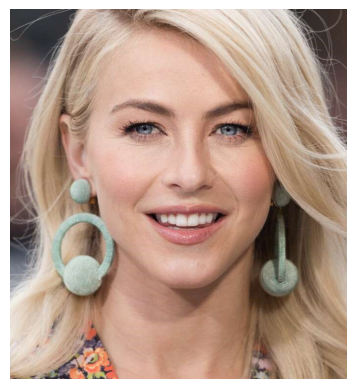

In [8]:
img = cv2.imread(train_files[0])
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

In [9]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            label_mode= 'categorical',
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)



Found 3251 files belonging to 5 classes.


In [1]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                           shuffle=True,
                                                           label_mode= 'categorical',
                                                           validation_split = 0.33,
                                                           subset = "training",
                                                           batch_size=BATCH_SIZE,
                                                           image_size=IMG_SIZE,
                                                           seed = 1)


NameError: name 'tf' is not defined

In [2]:
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                          shuffle=True,
                                                          label_mode= 'categorical',
                                                          validation_split = 0.33,
                                                          subset = "validation",
                                                          batch_size=BATCH_SIZE,
                                                          image_size=IMG_SIZE,
                                                          seed = 1)

NameError: name 'tf' is not defined

In [1]:
print("hello")

hello


In [1]:
val_dataset

NameError: name 'val_dataset' is not defined